QRNG: By Random Qubits

Team Members:
Heramb Kumar Karil, S Abhay, Manvendra Singh

In [1]:
# Importing libraries
from qiskit import *
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib.pyplot as plt
import numpy as np
import math
import mthree as m3

We start by exploring how much qubits are required based on the number of desirable outcomes we wish to have from our QRNG, which is, number of qubits =  log2(Number of outcomes)

In [2]:
def log_floor_base_2(n):
    return math.floor(math.log2(n))

Analysis on a shorter circuit, where n = 5

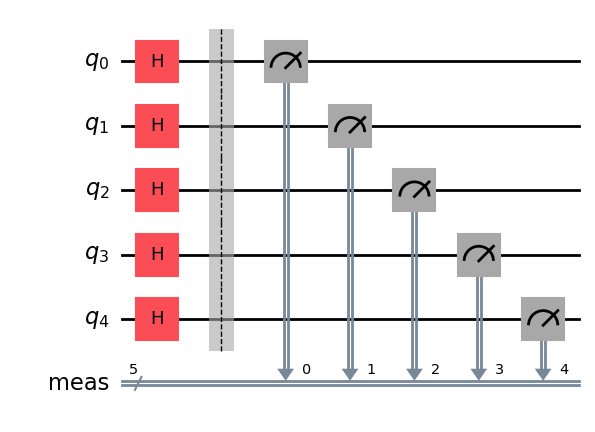

In [3]:
distint_values_required = 32
num_qubits = log_floor_base_2(distint_values_required)

qc  = QuantumCircuit(num_qubits)

for qubit in range(num_qubits):
    qc.h(qubit)

qc.measure_all()

qc.draw('mpl')

1. Simulated on StetvectorSampler() backend

In [4]:
sampler = StatevectorSampler() 
pub = (qc) 
job_sampler = sampler.run([pub], shots=1024) 


result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

In [5]:
def convert_counts_to_decimal(counts_sampler):
    decimal_counts = {}
    for bitstring, count in counts_sampler.items():
        decimal_value = int(bitstring, 2)  # Convert binary string to decimal
        decimal_counts[decimal_value] = count
    return decimal_counts

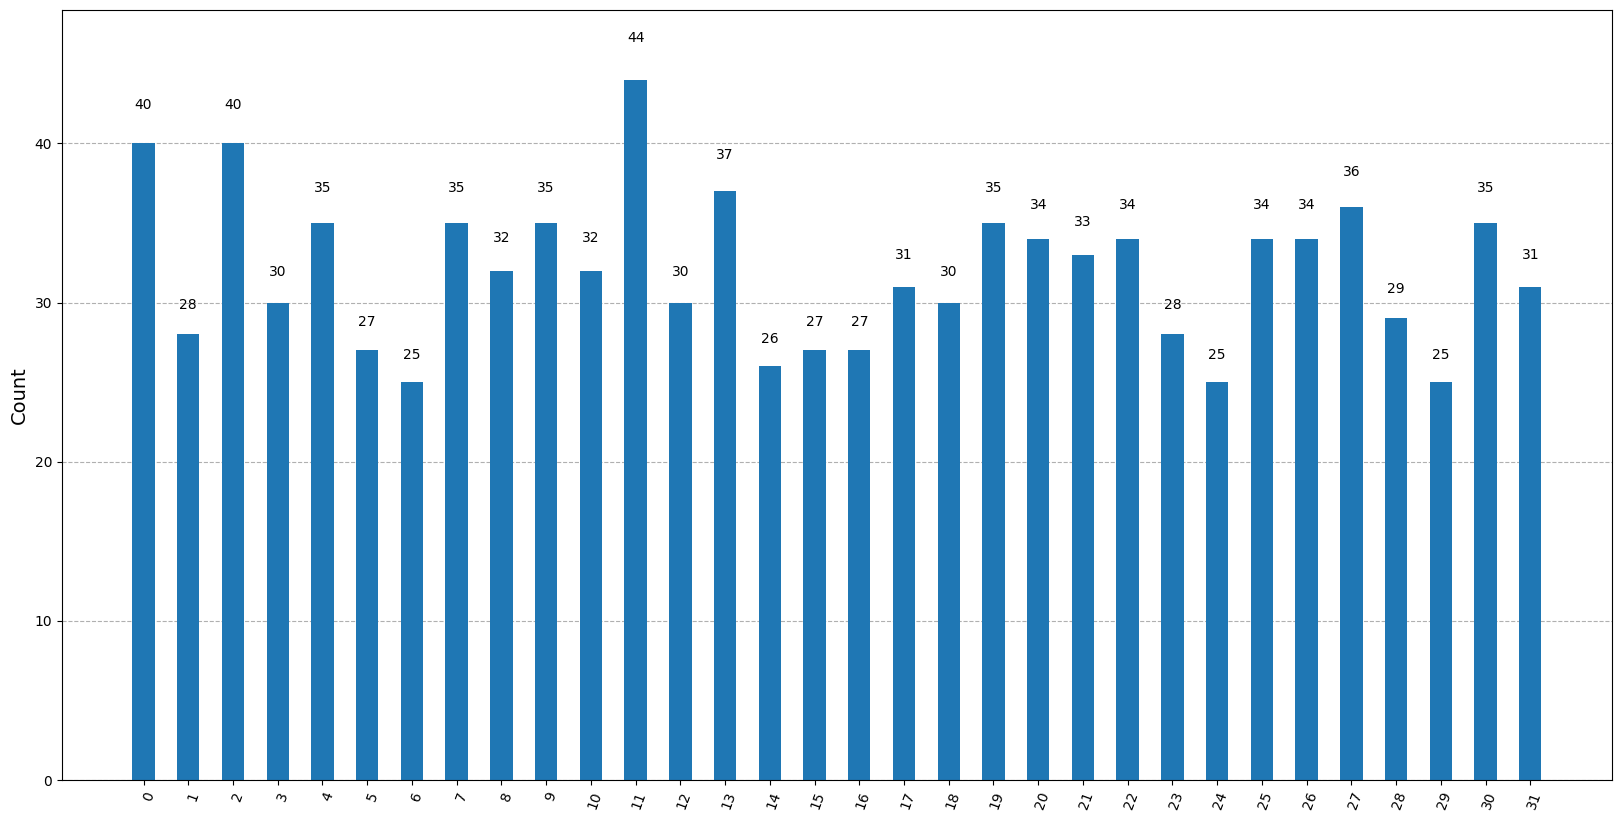

In [6]:
plot_histogram(convert_counts_to_decimal(counts_sampler), figsize=(20,10))

In [7]:
def calculate_mean_and_std(data_dict):
    # Get the experimental counts (rhs values)
    counts = list(data_dict.values())

    # Calculate the mean
    mean = sum(counts) / len(counts)

    # Calculate the variance
    variance = sum((x - mean) ** 2 for x in counts) / len(counts)

    # Standard deviation is the square root of the variance
    std_dev = math.sqrt(variance)

    return mean, std_dev

In [8]:
mean0, std_dev0 = calculate_mean_and_std(convert_counts_to_decimal(counts_sampler))
print(f"Mean: {mean0}")
print(f"Standard Deviation: {std_dev0}")

Mean: 32.0
Standard Deviation: 4.636809247747852


2. Running on FakeBackend for Testing out error correction techniques

In [9]:
backend = FakeTorino()
sampler = Sampler(mode=backend)

In [10]:
circuit = qc
pm_3e1 = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)
isa_circuit = pm_3e1.run(circuit)

sampler = Sampler(mode=backend)
#DD error correction
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

job = sampler.run([isa_circuit],shots=1024)

result1 = job.result()
counts1 = result1[0].data.meas.get_counts()

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


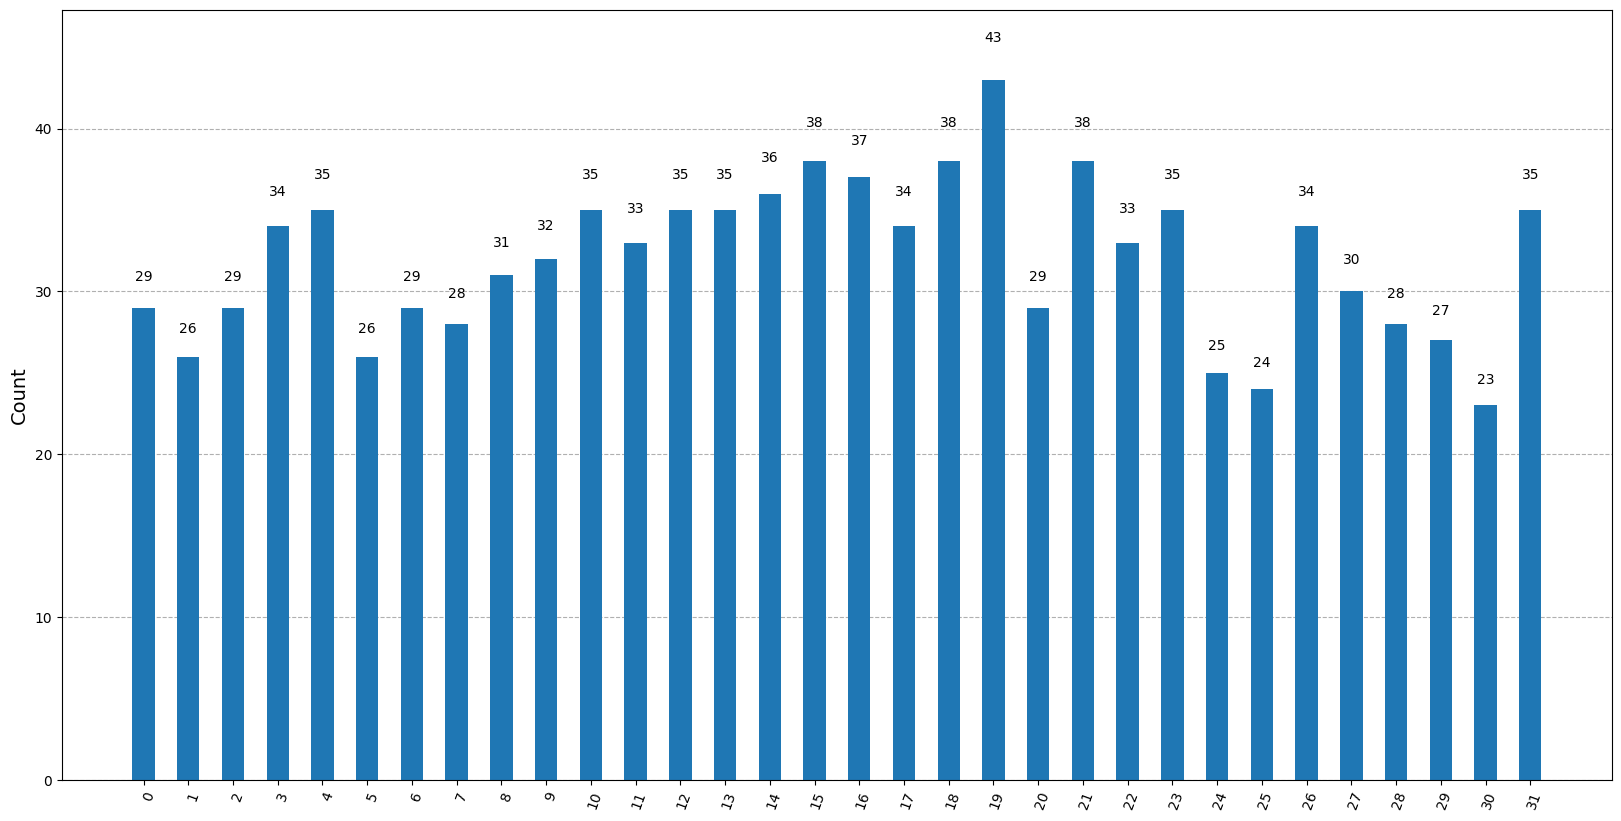

In [11]:
plot_histogram(convert_counts_to_decimal(counts1), figsize=(20,10))

In [12]:
mean1, std_dev1 = calculate_mean_and_std(convert_counts_to_decimal(counts1))
print(f"Mean: {mean1}")
print(f"Standard Deviation: {std_dev1}")

Mean: 32.0
Standard Deviation: 4.683748498798798


In [13]:
circuit = qc
pm_3e2 = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)
isa_circuit = pm_3e2.run(circuit)

#pauli twirling error correction
sampler = Sampler(mode=backend)
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
sampler.options.twirling.shots_per_randomization = "auto"


job = sampler.run([isa_circuit],shots=1024)

result2 = job.result()
counts2 = result2[0].data.meas.get_counts()

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


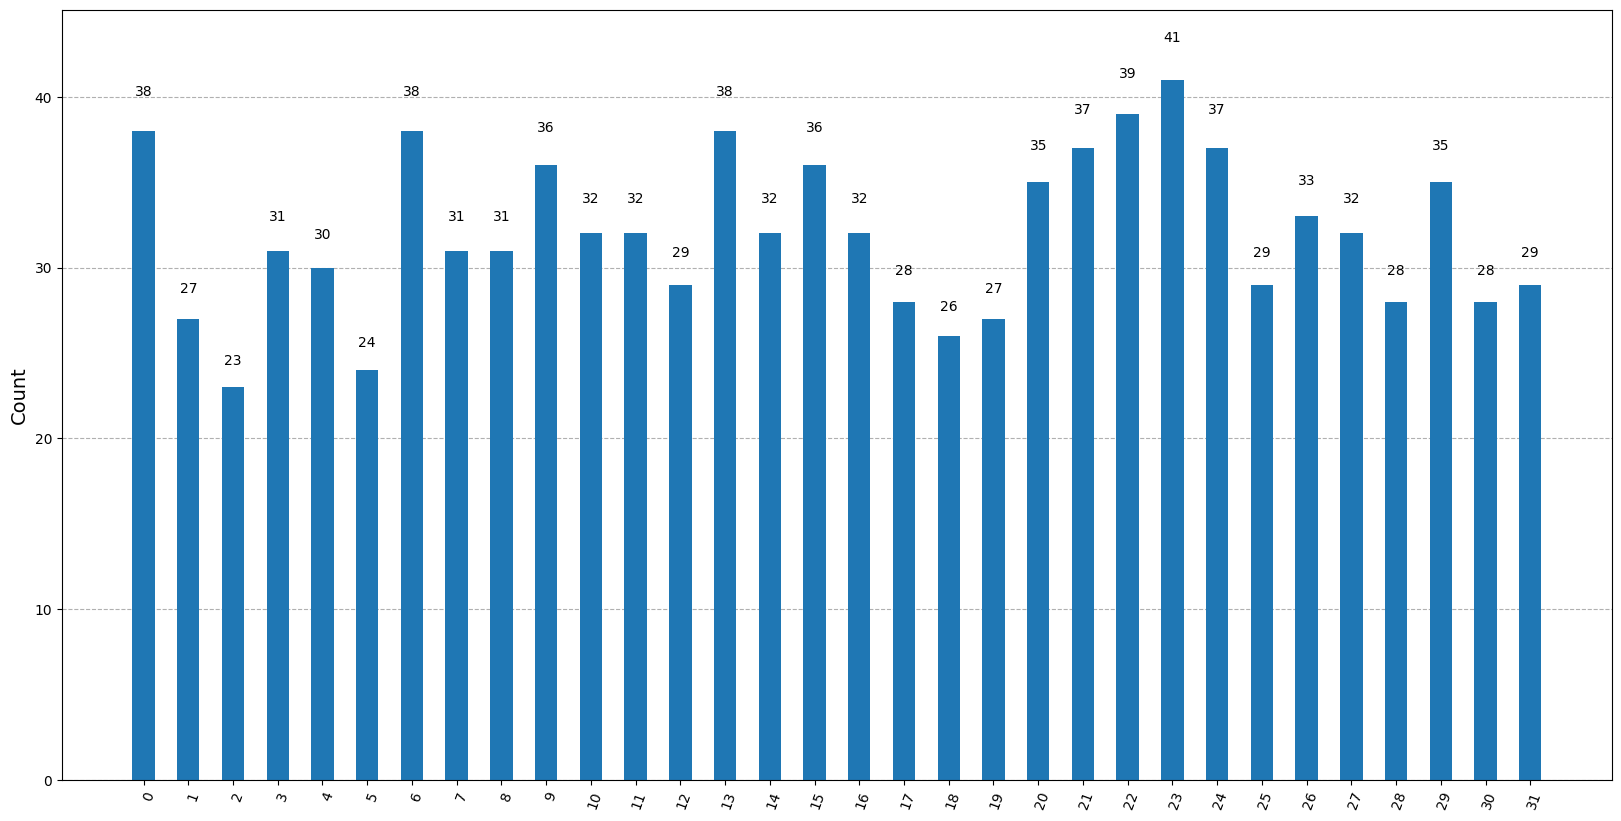

In [14]:
plot_histogram(convert_counts_to_decimal(counts2), figsize=(20,10))

In [15]:
mean2, std_dev2 = calculate_mean_and_std(convert_counts_to_decimal(counts2))
print(f"Mean: {mean2}")
print(f"Standard Deviation: {std_dev2}")

Mean: 32.0
Standard Deviation: 4.513867521316947


In [16]:
circuit = qc
pm_3e3 = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)
isa_circuit = pm_3e3.run(circuit)

# M3 error correction
mit = m3.M3Mitigation(backend)
mit.cals_from_system(range(num_qubits))

job = sampler.run([isa_circuit],shots=1024)
result3 = job.result()
counts3 = result3[0].data.meas.get_counts()

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


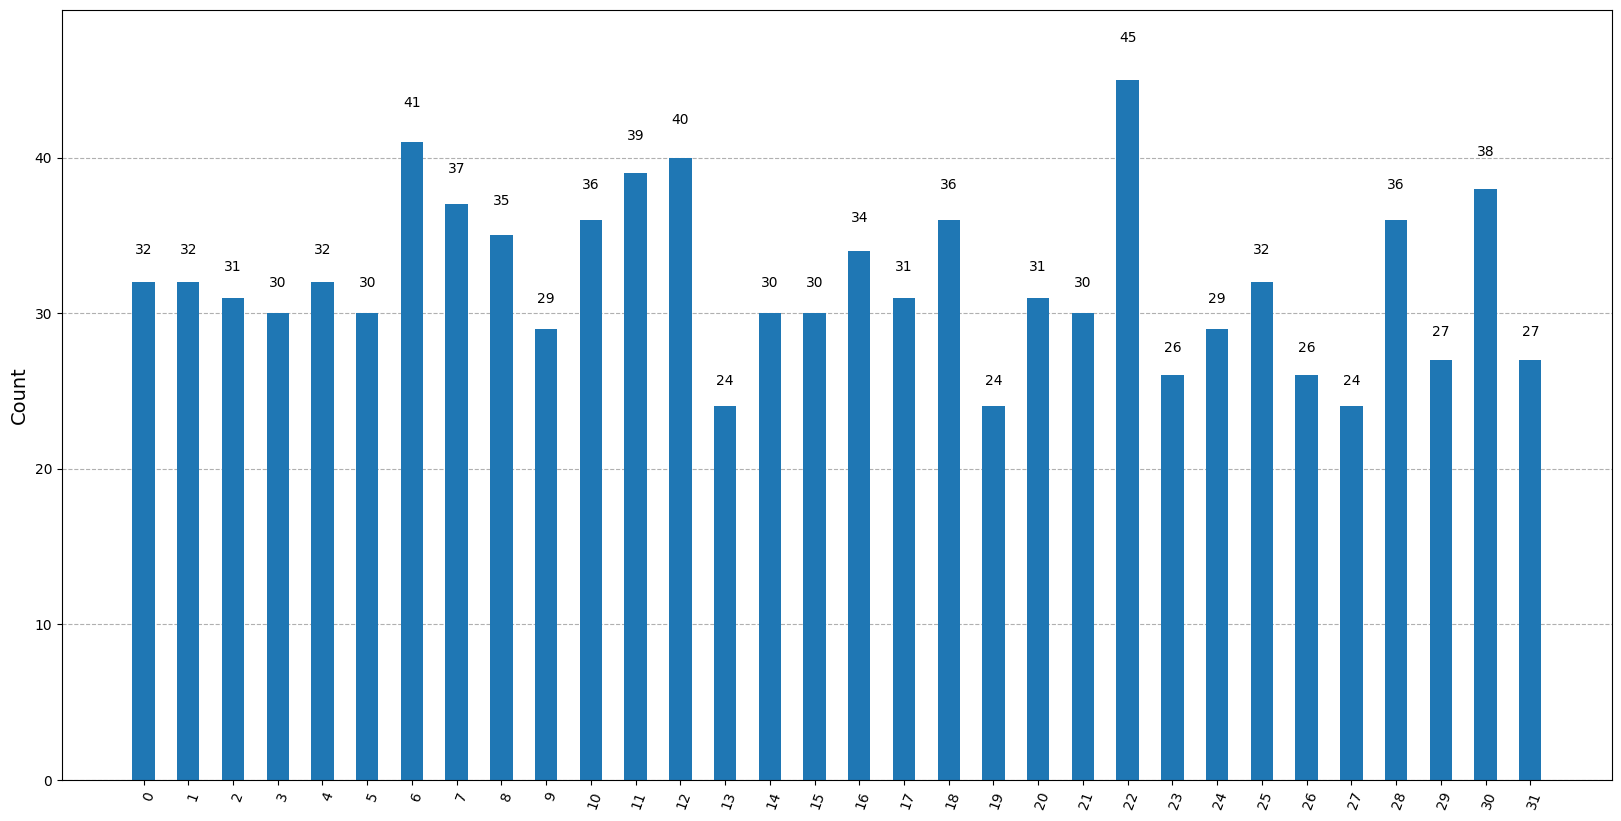

In [17]:
plot_histogram(convert_counts_to_decimal(counts3), figsize=(20,10))

In [18]:
mean3, std_dev3 = calculate_mean_and_std(convert_counts_to_decimal(counts3))
print(f"Mean: {mean3}")
print(f"Standard Deviation: {std_dev3}")


Mean: 32.0
Standard Deviation: 5.123475382979799


3. Comparision of error correction techniques to simulation

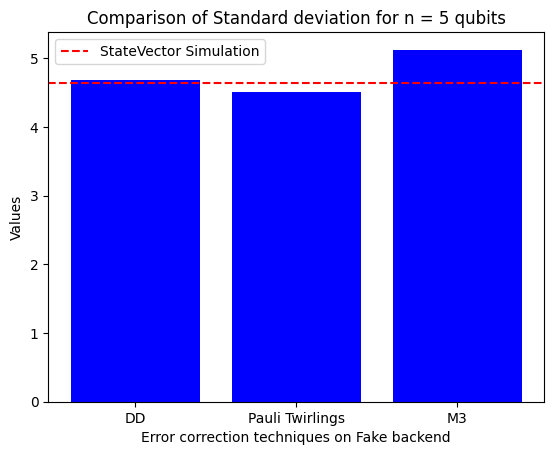

In [19]:
values = [std_dev0, std_dev1, std_dev2, std_dev3]
labels = ['StateVector', 'DD', 'Pauli Twirlings', 'M3']

# Create a bar plot
plt.bar(labels[1:], values[1:], color='b')  # Plot DD, Pauli Twirlings, and M3

# Add a vertical line for StateVector
plt.axhline(y=std_dev0, color='r', linestyle='--', label='StateVector Simulation')

# Adding title and labels
plt.title('Comparison of Standard deviation for n = 5 qubits')
plt.xlabel('Error correction techniques on Fake backend')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


Scaling up to analyse on a bigger circuit, where n = 10

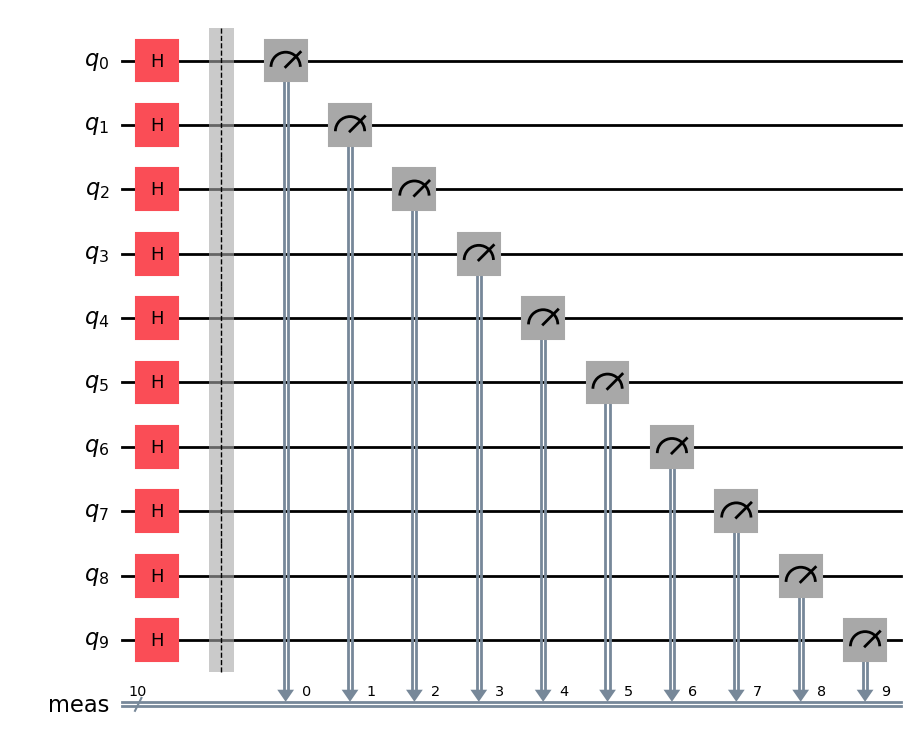

In [20]:
distint_values_required = 1024
num_qubits = log_floor_base_2(distint_values_required)

qc  = QuantumCircuit(num_qubits)

for qubit in range(num_qubits):
    qc.h(qubit)

qc.measure_all()

qc.draw('mpl')

1. Simulated on StetvectorSampler() backend

In [21]:
sampler = StatevectorSampler() 
pub = (qc) 
job_sampler = sampler.run([pub], shots=32768) 


result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

#plot_histogram(convert_counts_to_decimal(counts_sampler), figsize=(200,10))

In [22]:
mean00, std_dev00 = calculate_mean_and_std(convert_counts_to_decimal(counts_sampler))
print(f"Mean: {mean00}")
print(f"Standard Deviation: {std_dev00}")

Mean: 32.0
Standard Deviation: 5.616138853785579


2. Running on FakeBackend for Testing out error correction techniques

In [23]:
circuit = qc
pm_3e1 = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)
isa_circuit = pm_3e1.run(circuit)

sampler = Sampler(mode=backend)
#DD error correction
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

job = sampler.run([isa_circuit],shots=32768)

result1 = job.result()
counts1 = result1[0].data.meas.get_counts()

#plot_histogram(convert_counts_to_decimal(counts1), figsize=(200,10))

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [24]:
mean11, std_dev11 = calculate_mean_and_std(convert_counts_to_decimal(counts1))
print(f"Mean: {mean11}")
print(f"Standard Deviation: {std_dev11}")

Mean: 32.0
Standard Deviation: 5.701733563136742


In [25]:
circuit = qc
pm_3e2 = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)
isa_circuit = pm_3e2.run(circuit)

#pauli twirling error correction
sampler = Sampler(mode=backend)
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
sampler.options.twirling.shots_per_randomization = "auto"


job = sampler.run([isa_circuit],shots=32768)

result2 = job.result()
counts2 = result2[0].data.meas.get_counts()

#plot_histogram(convert_counts_to_decimal(counts2), figsize=(200,10))

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [26]:
mean22, std_dev22 = calculate_mean_and_std(convert_counts_to_decimal(counts2))
print(f"Mean: {mean22}")
print(f"Standard Deviation: {std_dev22}")

Mean: 32.0
Standard Deviation: 5.705329197338222


In [27]:
circuit = qc
pm_3e3 = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)
isa_circuit = pm_3e3.run(circuit)

# M3 error correction
mit = m3.M3Mitigation(backend)
mit.cals_from_system(range(num_qubits))

job = sampler.run([isa_circuit], shots=32768)
result3 = job.result()
counts3 = result3[0].data.meas.get_counts()

# plot_histogram(convert_counts_to_decimal(counts3), figsize=(200,10))

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [28]:
mean33, std_dev33 = calculate_mean_and_std(convert_counts_to_decimal(counts3))
print(f"Mean: {mean33}")
print(f"Standard Deviation: {std_dev33}")

Mean: 32.0
Standard Deviation: 5.845671475544961


3. Comparision of error correction techniques to simulation

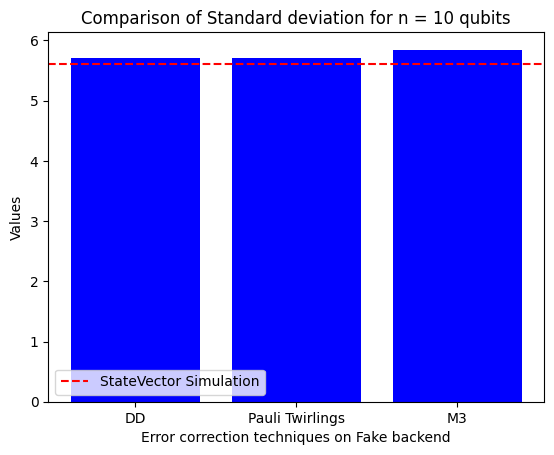

In [29]:
values0 = [std_dev00, std_dev11, std_dev22, std_dev33]
labels = ['StateVector', 'DD', 'Pauli Twirlings', 'M3']

# Create a bar plot
plt.bar(labels[1:], values0[1:], color='b')  # Plot DD, Pauli Twirlings, and M3

# Add a vertical line for StateVector
plt.axhline(y=values0[0], color='r', linestyle='--', label='StateVector Simulation')

# Adding title and labels
plt.title('Comparison of Standard deviation for n = 10 qubits')
plt.xlabel('Error correction techniques on Fake backend')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

Analysis Conclusion

1. For shallower circuits with lesser numbr of shots M3 is able to get QRNG distribution close to the one produced by StateVectorSampler Simulator
2. For much denser circuits or systems with more shots, the error correction techniques for sampler estimator all work well and are almost close to replicating StateVectorSampler Simulator

Usable QRNG, on a fakebackend with M3 error correction

In [32]:
# User enters required number of distinct values
distint_values_required = 1024
# Preparing quantum circuit as per requirement and constraints
num_qubits = log_floor_base_2(distint_values_required)
qrng_qc  = QuantumCircuit(num_qubits)
for qubit in range(num_qubits):
    qrng_qc.h(qubit)
qrng_qc.measure_all()
# Transpiling the circuit to make it scalable as well as quantum device independent
pm_qrng = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm_qrng.run(qrng_qc)
# M3 error correction
mit = m3.M3Mitigation(backend)
mit.cals_from_system(range(num_qubits))
#Producing QRNG
job = sampler.run([isa_circuit], shots=1)
result_qrng = job.result()
counts_qrng = result_qrng[0].data.meas.get_counts()

C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:234: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [33]:
print (f"The random number generated from our QRNG is: {int(str(list(counts_qrng.keys())[0]),2)}")


The random number generated from our QRNG is: 42


About our QRNG:
1. User can decide the required number of distinct values, manually through code
2. Scalabe to n qubits for a fake backend (not the case for an actual qauntum computer, depends on its constraints for number of qubits in the circuit)
3. Scalable to any quantum device thanks for high level of transpilation of the circuit
4. Uses M3 error mitigation, which works fro shallow and dense cicuits better than other sampler compatible error correction methods, as shown in analysis